RBF and MMDLoss classes are copied from https://github.com/yiftachbeer/mmd_loss_pytorch with some changes
Some inspiration from https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy
Autoencoder code from https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

In [40]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as trans

In [41]:
class RBF(nn.Module):

    def __init__(self, bandwidth=None): #bandwidth = sigma
        super().__init__()
        self.bandwidth_multipliers = torch.tensor([0.5, 1, 5, 10, 20, 40], dtype = torch.float32)
        self.bandwidth = bandwidth

    def get_bandwidth(self):
        if self.bandwidth is None:
            return 1
        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2 
        return torch.exp(-0.5 * L2_distances[None, ...] / ((self.get_bandwidth() * self.bandwidth_multipliers)**2)[:, None, None]).sum(dim=0) - 6*torch.eye(len(X), dtype=torch.float32)

class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        Y_size = Y.shape[0]
        XX = K[:X_size, :X_size].sum() / (X_size**2-X_size)
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].sum() / (Y_size**2-Y_size)
        return XX - 2 * XY + YY

Parameters:

In [42]:
N_batch = 500
N_epochs = 50
N_input = 50

N_batch_AE = 128
N_epochs_AE = 32


Load MNIST data:

In [43]:
trainds = torchvision.datasets.MNIST(root='./data', 
                                          train=True, 
                                          transform=trans.ToTensor(),  
                                          download=True)
trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch, 
                                           shuffle=True)
AE_trainldr = torch.utils.data.DataLoader(dataset=trainds, 
                                           batch_size=N_batch_AE, 
                                           shuffle=True)

Define and train autoencoder:

In [44]:
np.random.seed(123)
torch.manual_seed(123)

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Encoder
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10),
            torch.nn.Sigmoid()
        )
        
        # Decoder
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 400),
            torch.nn.ReLU(),
            torch.nn.Linear(400, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,enc):
        return self.decoder(enc)
    
autoencoder = AE()

# MSE Loss function
AE_loss_fn = torch.nn.MSELoss()
 
# Adam Optimizer with lr = 0.1
AE_optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr = 0.001)

for epoch in range(N_epochs_AE):
    for idx, (img, lbls) in enumerate(AE_trainldr): 
        img = img.reshape(-1, 28*28)
        
        reconstructed = autoencoder(img)

        loss = AE_loss_fn(img, reconstructed)
        AE_optimizer.zero_grad() 
        loss.backward() 
        AE_optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.05141172558069229
Finished epoch 1, latest loss 0.04438933730125427
Finished epoch 2, latest loss 0.03684049844741821
Finished epoch 3, latest loss 0.03498641774058342
Finished epoch 4, latest loss 0.03475154936313629
Finished epoch 5, latest loss 0.03136299550533295
Finished epoch 6, latest loss 0.02620449848473072
Finished epoch 7, latest loss 0.028253160417079926
Finished epoch 8, latest loss 0.02787221595644951
Finished epoch 9, latest loss 0.027948856353759766
Finished epoch 10, latest loss 0.02518404833972454
Finished epoch 11, latest loss 0.027635985985398293
Finished epoch 12, latest loss 0.023633524775505066
Finished epoch 13, latest loss 0.02499629743397236
Finished epoch 14, latest loss 0.023556528612971306
Finished epoch 15, latest loss 0.02342957630753517
Finished epoch 16, latest loss 0.022861577570438385
Finished epoch 17, latest loss 0.021047981455922127
Finished epoch 18, latest loss 0.02138853259384632
Finished epoch 19, latest loss 0.0

Autoencoder output:

5


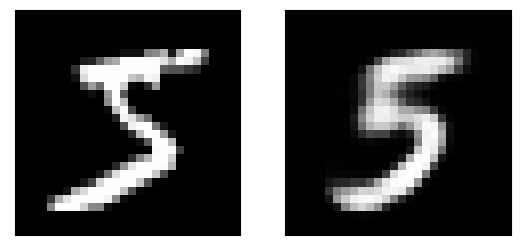

In [51]:
plt.gray()

ax = plt.subplot(1, 2, 1)
(img_data, lbl) = trainds[0]
img_data = img_data.reshape(28, 28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_data)
print(lbl)

ax = plt.subplot(1, 2, 2)
img_reshaped = img_data.reshape(1,-1)
img_reconstructed = autoencoder(img_reshaped)
img_reconstructed = img_reconstructed.reshape(28,28)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(img_reconstructed.detach())

Define MMD network:

In [46]:
class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(N_input, 200)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(200, 100)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(100, 100)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(100, 200)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(200, 10)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x
    
model = network()

loss_fn = MMDLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

Train MMD network on 10-dimensional autoencoder feature space:

In [47]:
np.random.seed(903)
torch.manual_seed(903)

for epoch in range(N_epochs):
    for idx, (x, lbls) in enumerate(trainldr):
        x = x.reshape(-1, 28*28) 
        x = autoencoder.encode(x)

        x_input = np.random.uniform(-0.5,0.5,N_batch*N_input)
        x_input = torch.tensor(x_input, dtype=torch.float32).reshape(N_batch, N_input)

        x_output = model(x_input)

        loss = loss_fn(x, x_output)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.14262819290161133
Finished epoch 1, latest loss 0.0734095573425293
Finished epoch 2, latest loss 0.04967021942138672
Finished epoch 3, latest loss 0.04340934753417969
Finished epoch 4, latest loss 0.038979530334472656
Finished epoch 5, latest loss 0.026581287384033203
Finished epoch 6, latest loss 0.019283294677734375
Finished epoch 7, latest loss 0.014651775360107422
Finished epoch 8, latest loss 0.01117706298828125
Finished epoch 9, latest loss 0.013296127319335938
Finished epoch 10, latest loss 0.018100261688232422
Finished epoch 11, latest loss 0.008412837982177734
Finished epoch 12, latest loss 0.010143280029296875
Finished epoch 13, latest loss 0.008353710174560547
Finished epoch 14, latest loss 0.009030818939208984
Finished epoch 15, latest loss 0.003517627716064453
Finished epoch 16, latest loss 0.004523754119873047
Finished epoch 17, latest loss 0.005869865417480469
Finished epoch 18, latest loss 0.004748344421386719
Finished epoch 19, latest lo

Visualize model outputs:

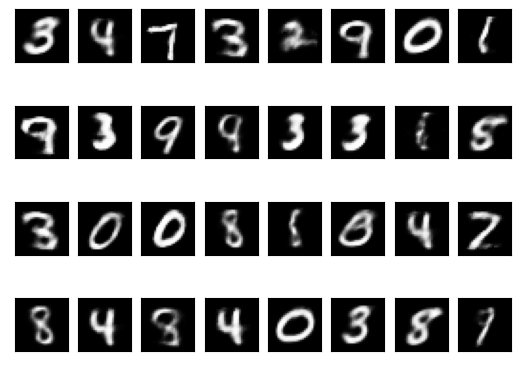

In [49]:
np.random.seed(0)

noises = []
plt.gray()
for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)
    noise = np.random.uniform(-0.5,0.5,N_input)
    noise = torch.tensor(noise, dtype=torch.float32).reshape(1,-1)
    test = model(noise)
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    noises.append(noise)
plt.show()

Plot nearest neighbours:

tensor([[0.1099]], grad_fn=<CdistBackward0>)
tensor([[0.0772]], grad_fn=<CdistBackward0>)
tensor([[0.1786]], grad_fn=<CdistBackward0>)
tensor([[0.1236]], grad_fn=<CdistBackward0>)


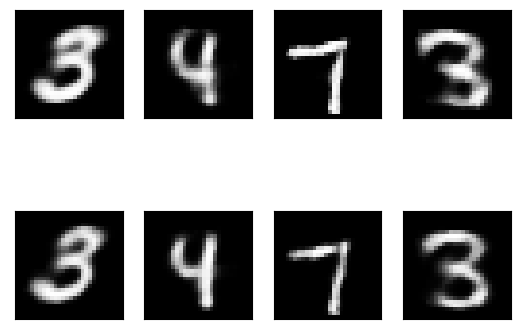

In [50]:
for i in range(4):
    ax = plt.subplot(2, 4, i+1)
    with torch.no_grad():
        test = model(noises[i])
    image = autoencoder.decode(test)
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    smallest = 0 #index such that MMD of image and train image is smallest using euclidean dist
    dist = float('inf')
    for j in range(len(trainds)):
        train = autoencoder.encode(trainds[j][0].reshape(-1,28*28))
        dist_new = torch.cdist(test,train) #test is in feature space
        if dist_new < dist: 
            dist = dist_new
            smallest = j
    ax = plt.subplot(2, 4, 5+i)
    image = autoencoder(trainds[smallest][0].reshape(-1, 28*28))
    plt.imshow(image.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    print(dist)
plt.show()